In [238]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from itertools import combinations
import statistics
import math

In [293]:
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/Asian_site_ard2.csv')
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_NSR.csv')
dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_SR.csv')
dataframe = dataframe[dataframe["Coincidence"] < 1].reset_index()
dataframe = dataframe.drop(columns=["index"])
dataframe = dataframe[dataframe['Salinity']>20]

In [294]:
tempdf = pd.DataFrame()
tempdf['Tmean'] = dataframe[['pH','Salinity','Ammonia']].mean()
tempdf['Tstd'] = dataframe[['pH','Salinity','Ammonia']].std()
for date in dataframe['Date of Image'].unique():
  df = dataframe.loc[dataframe['Date of Image'] == date]
  tempdf[f'{date}_mean'] = df[['pH','Salinity','Ammonia']].mean()
  tempdf[f'{date}_std'] = df[['pH','Salinity','Ammonia']].std()

In [295]:
tempdf

,Tmean,Tstd,2022-07-14_mean,2022-07-14_std,2022-09-12_mean,2022-09-12_std,2023-04-25_mean,2023-04-25_std,2023-05-30_mean,2023-05-30_std,2023-07-09_mean,2023-07-09_std
pH,8.205357,0.361522,8.600,0.106904,8.43750,0.170783,7.6250,0.150000,7.900000,0.264575,8.166667,0.276887
Salinity,33.678571,6.390638,37.875,1.807722,35.56250,3.898183,26.0000,3.366502,24.923077,1.754116,39.066667,2.051712
Ammonia,0.043750,0.032784,0.000,0.000000,0.02625,0.015438,0.0275,0.009574,0.074615,0.025038,0.063333,0.024398


In [296]:
dataframe.head()

,PondID,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,...,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,TUPILIPALEM_A2,8.4,35,30,120,150,6300,388,1296,0.0,...,821,759,964,800,1132,1074,1130,924,1135,1643
1,TUPILIPALEM_A3,8.7,38,40,120,160,6800,472,1471,0.0,...,645,645,833,639,879,885,971,696,911,1296
2,TUPILIPALEM_A4,8.7,39,40,110,150,6960,482,1488,0.0,...,573,541,694,528,768,633,710,574,801,1673
3,TUPILIPALEM_A5,8.7,40,40,120,160,7100,488,1491,0.0,...,699,558,662,637,699,780,869,538,858,1599
4,TUPILIPALEM_B2,8.6,36,50,110,160,6200,378,1302,0.0,...,957,732,968,1040,1261,1274,1236,808,1200,1759


In [297]:
print("pH Minimum Value:", dataframe["pH"].min())
print("Salinity Minimum Value:", dataframe["Salinity"].min())

pH Minimum Value: 7.5
Salinity Minimum Value: 22


In [298]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
wavelengths = [442.7,	492.4,559.8,664.6,704.1,740.5,782.8,832.8,864.7,945.1,1373.5,1613.7,2202.4]
parameters = ["pH", "Salinity", "Ammonia"]

In [299]:
dataframe[["pH", "Salinity", "Ammonia"]].std()/np.array([8.5, 45, 0.5])

pH          0.042532
Salinity    0.142014
Ammonia     0.065567
dtype: float64

## WQI calculation

In [300]:
# def derivative(dataframe):
#     banddata = dataframe[bands]
#     for wave,band in (wavelengths,bands):



#     return None

def calculateWQI(parameters):
    # order of parameters ph salinity ammonia
    expdf = pd.DataFrame()
    permissibleValuesParameters = np.array([8.5, 45, 0.5])
    summ = 0
    sumWn = 0
    weights =   np.array([0.30,0.30,0.4]) # np.array(parameters.std()/permissibleValuesParameters)
    weightsnormalized = weights/sum(weights)
    for column, sn, Wn in zip(parameters.columns, permissibleValuesParameters, weightsnormalized):
        vn = parameters[column]
        if column=="pH":
            vid = 7.5
        elif column=="Salinity":
            vid = 0
        else:
            vid = 0.0
        qn = 100*(vn - vid)/(sn-vid)

        summ = summ + (qn*Wn)
        sumWn = sumWn + Wn
    expdf['summ'] = summ
    expdf['qn'] = qn
    WQI = summ/sumWn
    return WQI,expdf

def bandmath(bandMatrix,WQI):
  df = pd.DataFrame()
  cc = list(combinations(bandMatrix.columns,2))
  print(cc)
  for combination in cc:
    a = combination[0]
    b = combination[1]
    diffIndex = bandMatrix[a] - bandMatrix[b]
    normlizedIndex = (bandMatrix[a] - bandMatrix[b])/bandMatrix[a] + bandMatrix[b]
    ratioIndex = bandMatrix[a] / bandMatrix[b]
    df[f'diff_{a}_{b}'] = diffIndex
    df[f'norm_{a}_{b}'] = normlizedIndex
    df[f'ratio_{a}_{b}'] = ratioIndex
  df['WQI_cal'] = WQI
  return  df

def pca(data):
  pca = PCA(n_components=3)
  pca.fit(data)
  pca_data =  pca.transform(data)
  return  pca_data

def harmonizedWQIcalculation(GT):
  min = np.array([7.5,9,0])
  max = np.array([8.7,43,0.12])
  permissibleWP = np.array([8.5,45,0.5])
  weights =  np.array(GT.std()/permissibleWP)
  weights_norm = weights/sum(weights)
  numP = len(weights_norm)
  rr = max - min
  allWQI  = np.array([])
  n = len(GT)
  for val in GT.values:
    i = 0
    Tsumm = np.array([])
    for para in val:
        qi =None
        summ = 0
        if  min[i] <= para  <= 0.10*rr[i]:
          qi = 5
        if  0.1*min[i] <= para  <= 0.20*rr[i]:
          qi = 15
        if  0.20*rr[i] <= para  <= 0.30*rr[i]:
          qi = 25
        if  0.30*rr[i] <= para  <= 0.40*rr[i]:
          qi = 35
        if  0.40*rr[i] <= para  <= 0.50*rr[i]:
          qi = 45
        if  0.50*rr[i] <= para  <= 0.60*rr[i]:
          qi = 55
        if  0.60*rr[i] <= para  <= 0.70*rr[i]:
          qi = 65
        if  0.70*rr[i] <= para  <= 0.80*rr[i]:
          qi = 75
        if  0.80*rr[i] <= para  <= 0.90*rr[i]:
          qi = 85
        if  0.90*rr[i] <= para  <= max[i]:
          qi = 95
        # print(qi,para,rr[i])
        summ += 1/qi
        i+=1
        Tsumm = np.append(Tsumm,summ)
    WQI = sum([(weights_norm[i])*math.sqrt(i+1/Tsumm[i]**2) for i in range(numP)])/numP
    allWQI = np.append(allWQI,WQI)

  return allWQI


(array([ 2.,  4.,  4.,  2.,  3.,  7., 10.,  6., 13.,  5.]),
 array([17.86666667, 22.70666667, 27.54666667, 32.38666667, 37.22666667,
        42.06666667, 46.90666667, 51.74666667, 56.58666667, 61.42666667,
        66.26666667]),
 <BarContainer object of 10 artists>)

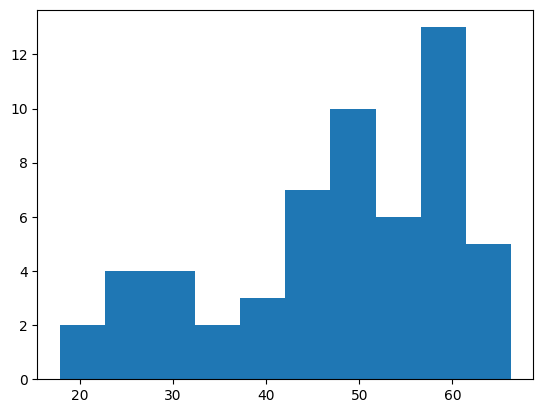

In [301]:
wqi,expdf= calculateWQI(dataframe[parameters])
## plotting distribution of wqi
plt.hist(wqi)

In [302]:

## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(wqi))
print("Standard Deviation WQI", statistics.stdev(wqi))

Mean WQI 47.113095238095234
Standard Deviation WQI 12.664516051194644


## Model for the WQI to indiviual parameter

In [303]:
def CM(actual, predicted):
  fig = plt.figure()
  plt.scatter(actual, predicted)
  plt.show()

def Presults(y_test, prediction):
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  # return model.coef_,model.intercept_

def LRegression(WQI,GT,WQI_val,GT_val):
  CM(GT,WQI)
  X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
  model = LinearRegression().fit(X_train, y_train)
  # model = SVR(kernel='rbf', C=2.0, epsilon=0.2).fit(X_train, y_train)
  if GT.name == 'Ammonia':
    # print('hi')
    model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
  prediction = model.predict(X_test)
  prediction_val = model.predict(WQI_val)
  for x,y in zip(y_test.values,prediction):
    print(x,'-',y)
  Presults(y_test, prediction)
  print(f"validation results on {GT_val.name}")
  Presults(GT_val,prediction_val)
  # for x,y in zip(GT_val,prediction_val):
  #   print(x,'-',y)
  # print(f"---------------------------------------")


#to predict the parameters from WQI



def WQIandParameters(WQI,GT,predictedWQI,gtforRE):
  print('-----For WQI with pH Regression relation-----')
  LRegression(WQI,GT['pH'],predictedWQI,gtforRE['pH'])
  print('-----For WQI with Salinity  Regression relation-----')
  LRegression(WQI,GT['Salinity'],predictedWQI,gtforRE['Salinity'])
  print('-----For WQI with Ammonia SVR relation-----')
  LRegression(WQI,GT['Ammonia'],predictedWQI,gtforRE['Ammonia'])
  return None



In [304]:
### adding wqi as a dataframe
dataframe["WQI"] = wqi

In [305]:
# sns.pairplot(dataframe)

## Model for Band to WQI index

In [306]:

def scaling(Banddata):
    scaler = StandardScaler()
    scaler.fit(Banddata)
    dataframe = scaler.transform(Banddata)
    return dataframe

def pca(dataframe):
  pca = PCA(n_components=3)
  pca.fit(dataframe)
  pca_df =  pca.transform(dataframe)
  return pca_df

# def weakmodel(xTrain, yTrain,xTest):
#       models = [
#         RandomForestRegressor(max_depth=3, random_state=0),
#         xgb.XGBRegressor(),
#         SVR(kernel='rbf', C=1.0, epsilon=1e-3)]

#       preds = []
#       for i, m in enumerate(models):
#           m.fit(xTrain, yTrain)
#           preds.append(m.predict(xTest))

#       weights = [0.33, 0.33,0.33]
#       preds = np.array(preds)
#       print
#       preds= np.sum(preds, axis = 0)/3
#       return preds

### model to predict WQI using bands as input
def predictWQI(dataframe,pred):
    validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

    # traindataframe, validationdataframe = train_test_split(dataframe, test_size=0.3, random_state=42)
    # traindataframe.to_csv('WQIModelTrain.csv')
    # validationdataframe.to_csv('WQIModelTest.csv')

    # validationdataframe = dataframe[dataframe["Date of Image"]=="2022-09-12"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2022-09-12"]
    k =  10
    k_fold = KFold(n_splits = k,shuffle=True )


    gtforRE = (validationdataframe[parameters])

    xTrain = (scaling(traindataframe[bands]))
    yTrain = traindataframe[pred]
    xTest = (scaling(validationdataframe[bands]))
    yTest = validationdataframe[pred]

    model = SVR(kernel='rbf', C=2.0, epsilon=1e-4)
    # model = RandomForestRegressor(max_depth=3, random_state=0)
    # model = MLPRegressor(random_state=1, max_iter=100000)

    model.fit(xTrain, yTrain)

    # score = cross_val_score(model, dataframe[bands], dataframe[pred], cv = k_fold)
    # print(sum(score) / len(score))
    # print(score)
    # prediction =  weakmodel(xTrain,yTrain,xTest)
    prediction = model.predict(xTest)
    # prediction = preds
    # print(prediction,yTest)

    print("MAE", mean_absolute_error(yTest, prediction))
    print("MSE", mean_squared_error(yTest, prediction))
    print("RMSE", mean_squared_error(yTest, prediction, squared=False))
    print("MAPE", mean_absolute_percentage_error(yTest, prediction))
    print("R2 Score", r2_score(yTest, prediction))
    plt.figure(figsize=(25,10))
    plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red")
    plt.plot(np.arange(1, len(yTest)+1), prediction, color="blue")
    return prediction,gtforRE

In [307]:
(dataframe).corrwith(dataframe['WQI'])

<ipython-input-307-d8a89629dacb>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['WQI'])


pH             0.943750
Salinity       0.766900
Carbonate      0.843038
BiCarbonate   -0.064482
Alkalinity     0.216350
Hardness      -0.041913
Calcium       -0.768902
Magnesium      0.752689
Ammonia       -0.319667
Coincidence         NaN
AOT           -0.732881
B1            -0.489707
B11           -0.471148
B12           -0.452358
B2            -0.549704
B3            -0.509143
B4            -0.517037
B5            -0.501159
B6            -0.468854
B7            -0.474713
B8            -0.490462
B8A           -0.447047
B9            -0.288718
WQI            1.000000
dtype: float64

(array([ 2.,  4.,  4.,  2.,  3.,  7., 10.,  6., 13.,  5.]),
 array([17.86666667, 22.70666667, 27.54666667, 32.38666667, 37.22666667,
        42.06666667, 46.90666667, 51.74666667, 56.58666667, 61.42666667,
        66.26666667]),
 <BarContainer object of 10 artists>)

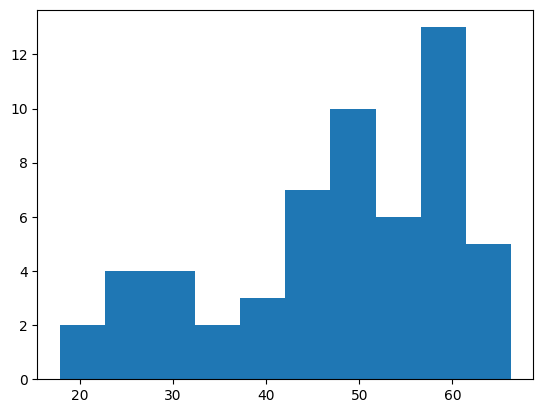

In [308]:

plt.hist(dataframe['WQI'])

MAE 7.117016222012149
MSE 72.56345158551417
RMSE 8.518418373472517
MAPE 0.15009634938497254
R2 Score 0.10965359819758935
-----For WQI with pH Regression relation-----


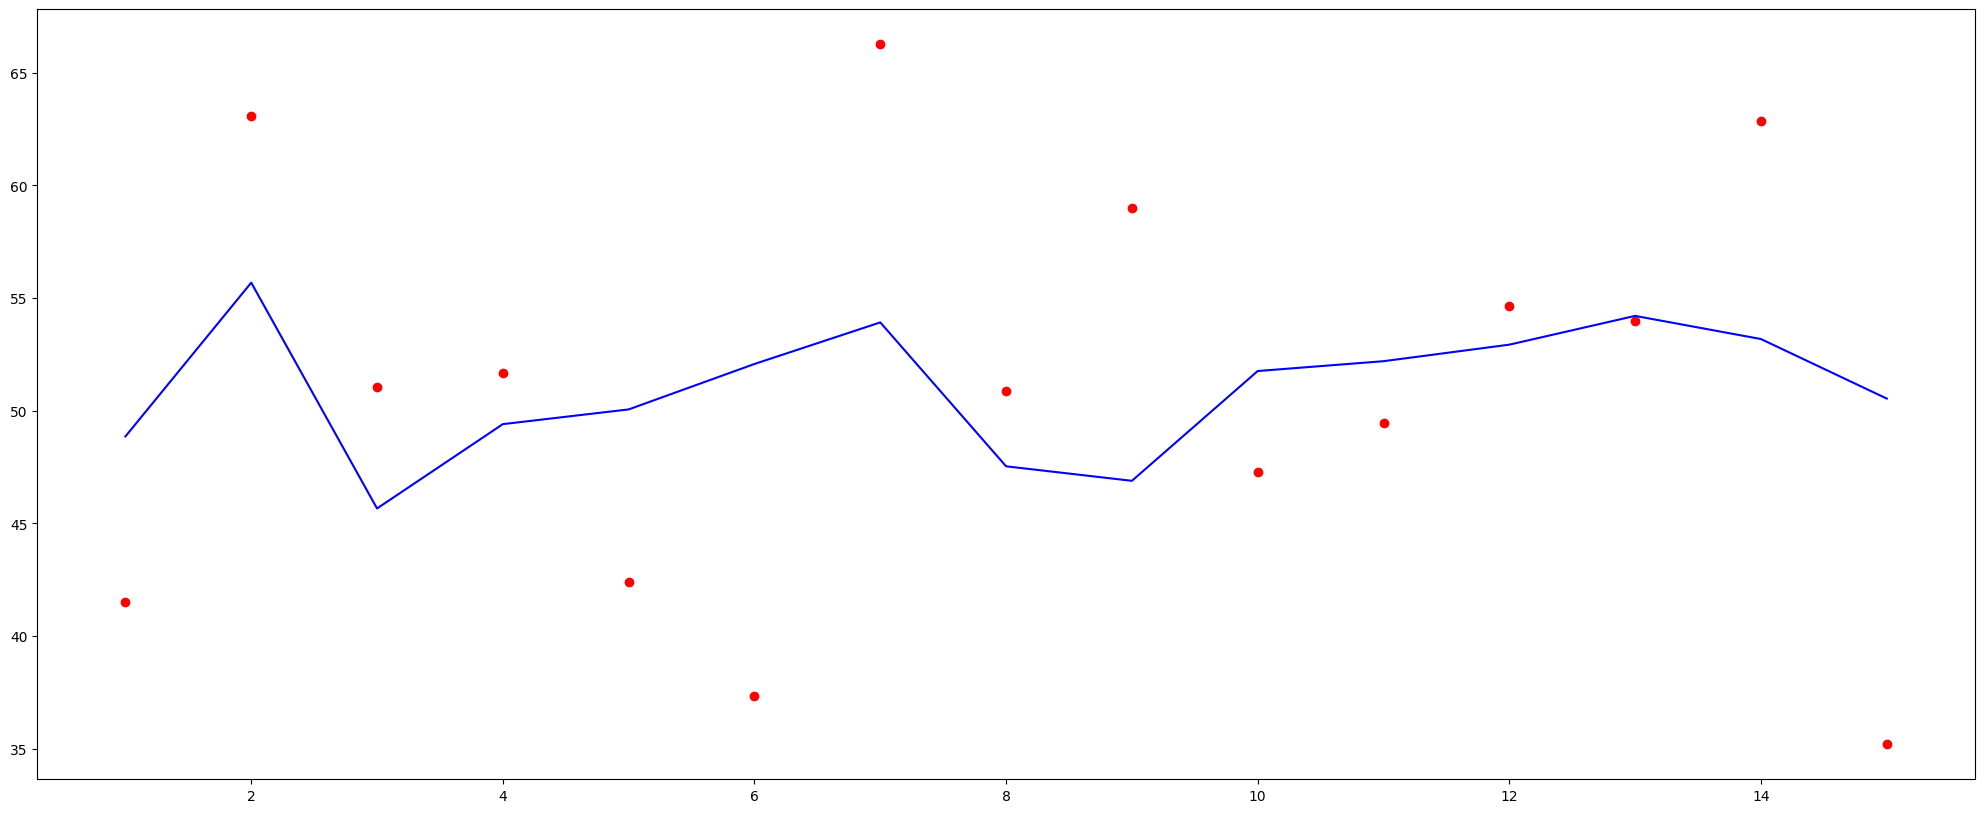

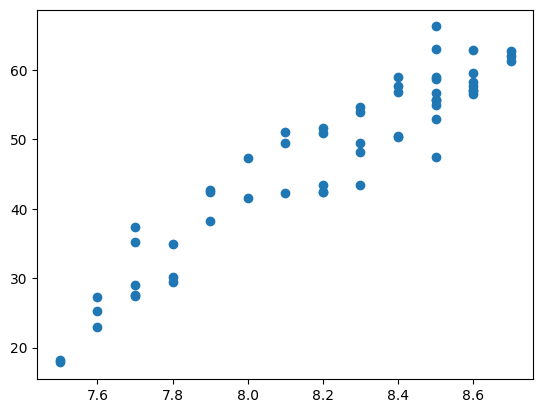

8.4 - 8.280007947769327
8.6 - 8.484558738778532
7.6 - 7.581126078487884
8.4 - 8.447057760426844
8.6 - 8.440239400726536
8.3 - 8.390806292899313
7.9 - 7.971477171330447
7.7 - 7.695333603468023
7.7 - 7.947612912379373
8.5 - 8.346486954847318
7.7 - 7.698742783318177
8.7 - 8.595357083908516
7.6 - 7.639082135940492
7.7 - 7.736243761669864
8.6 - 8.515241357429911
8.4 - 8.283417127619481
8.6 - 8.467512839527764
8.6 - 8.450466940276996
8.1 - 8.298758436945171
MAE 0.09960776923331771
MSE 0.014108425017333165
RMSE 0.11877889129526831
MAPE 0.012015207180133948
R2 Score 0.913234387883181
validation results on pH
MAE 0.21916088783839313
MSE 0.08172261558566399
RMSE 0.28587167678114594
MAPE 0.02741682152496082
R2 Score -0.14208624265679526
-----For WQI with Salinity  Regression relation-----


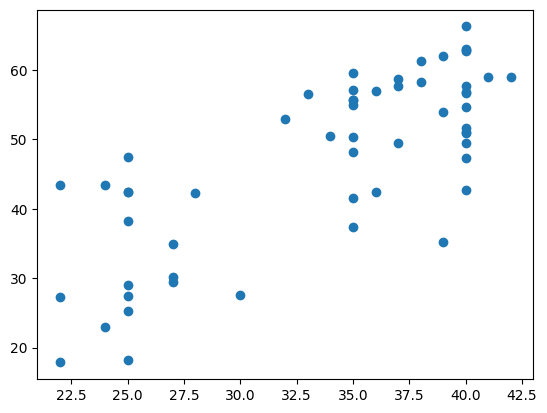

35 - 35.05591258371943
38 - 38.257145520945954
24 - 24.11836671486212
40 - 37.67025281578776
33 - 37.56354505121353
40 - 36.78991375805047
25 - 30.227386236736084
25 - 25.905721771480266
35 - 29.853909060726316
32 - 36.09631328831804
30 - 25.95907565376738
40 - 39.99114669527698
25 - 25.025382713742967
25 - 26.54596835892557
35 - 38.73733046152993
34 - 35.10926646600653
37 - 37.99037610951041
36 - 37.72360669807486
40 - 35.349358936298515
MAE 2.302245529218857
MSE 8.818292723364475
RMSE 2.9695610320996058
MAPE 0.070449311411218
R2 Score 0.7234227912133296
validation results on Salinity
MAE 3.8456570233499807
MSE 19.319459517474137
RMSE 4.395390712721013
MAPE 0.09624961463978103
R2 Score -3.917283248225883
-----For WQI with Ammonia SVR relation-----


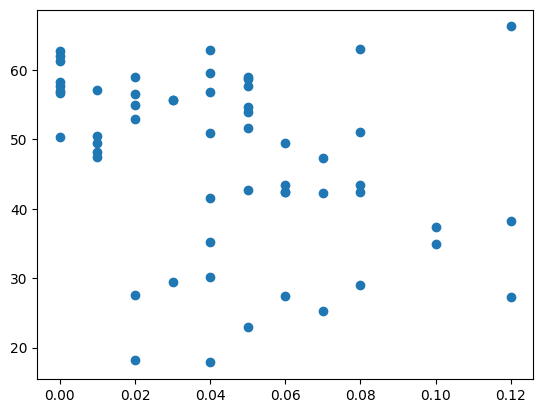

0.0 - 0.031179483394766692
0.0 - 0.028396749608970803
0.05 - 0.05954246826077787
0.04 - 0.028083694053415247
0.02 - 0.028083694053415247
0.05 - 0.029284481932203135
0.12 - 0.05883913116830378
0.06 - 0.06092648786862101
0.1 - 0.05883913116830378
0.02 - 0.03104823339476669
0.02 - 0.06092648786862101
0.0 - 0.04238858693829618
0.07 - 0.05954246826077787
0.08 - 0.05774003114551954
0.04 - 0.02800158831864822
0.01 - 0.031179483394766692
0.0 - 0.028396749608970803
0.0 - 0.028083694053415247
0.08 - 0.031457261172544465
MAE 0.025177070064509064
MSE 0.0008781314372405597
RMSE 0.029633282593066867
MAPE 37556527901447.0
R2 Score 0.3272380117915066
validation results on Ammonia
MAE 0.029810697876856005
MSE 0.0015035190602166533
RMSE 0.03877523771966657
MAPE 0.4055576990878347
R2 Score -1.7063343083899767


In [309]:
predictedWQI,gtforRE = predictWQI(dataframe,"WQI")
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)
WQIandParameters(np.array(dataframe['WQI']).reshape(-1, 1),dataframe[parameters],predictedWQI.reshape(-1, 1),gtforRE)

Mean WQI 51.15887456162535
Standard Deviation WQI 3.6433686823527327


(array([1., 1., 2., 2., 1., 3., 1., 2., 0., 2.]),
 array([44.75838372, 46.03119877, 47.30401381, 48.57682885, 49.8496439 ,
        51.12245894, 52.39527399, 53.66808903, 54.94090407, 56.21371912,
        57.48653416]),
 <BarContainer object of 10 artists>)

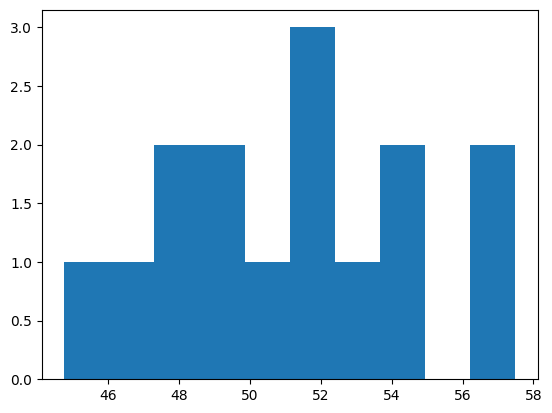

In [257]:
#
## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(predictedWQI))
print("Standard Deviation WQI", statistics.stdev(predictedWQI))
plt.hist(predictedWQI)

In [258]:
allWQI = harmonizedWQIcalculation(dataframe[parameters])
dataframe['HWQI'] = allWQI

(array([ 3.,  2.,  1., 20.,  5., 15.,  3.,  3.,  0.,  2.]),
 array([20.70053853, 21.7973438 , 22.89414906, 23.99095432, 25.08775959,
        26.18456485, 27.28137011, 28.37817538, 29.47498064, 30.5717859 ,
        31.66859117]),
 <BarContainer object of 10 artists>)

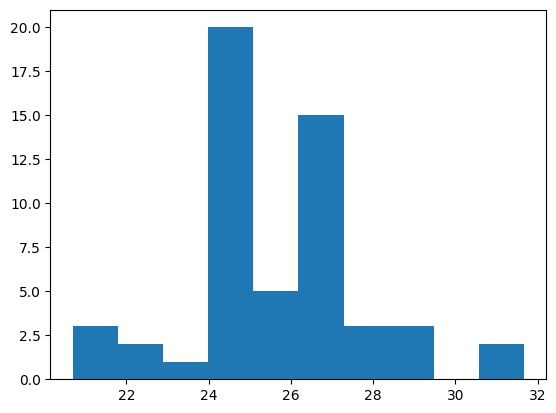

In [259]:
plt.hist(dataframe['HWQI'])

In [260]:
(dataframe).corrwith(dataframe['HWQI'])

<ipython-input-260-0036a586283d>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['HWQI'])


pH             0.037596
Salinity       0.539063
Carbonate     -0.090970
BiCarbonate   -0.042701
Alkalinity     0.061432
Hardness       0.530039
Calcium       -0.173239
Magnesium      0.442514
Ammonia        0.587396
Coincidence         NaN
Cloud Cover         NaN
B10           -0.436842
B11           -0.416639
B12           -0.412330
B1            -0.467068
B2            -0.529522
B3            -0.582201
B4            -0.551721
B5            -0.427773
B6            -0.373609
B7            -0.418933
B8A           -0.428528
B8            -0.466515
B9            -0.512347
WQI            0.345345
HWQI           1.000000
dtype: float64

MAE 3.77452495334928
MSE 16.094251354092663
RMSE 4.011764119946817
MAPE 0.1325446808269695
R2 Score -5.521352159920644
-----For WQI with pH Regression relation-----


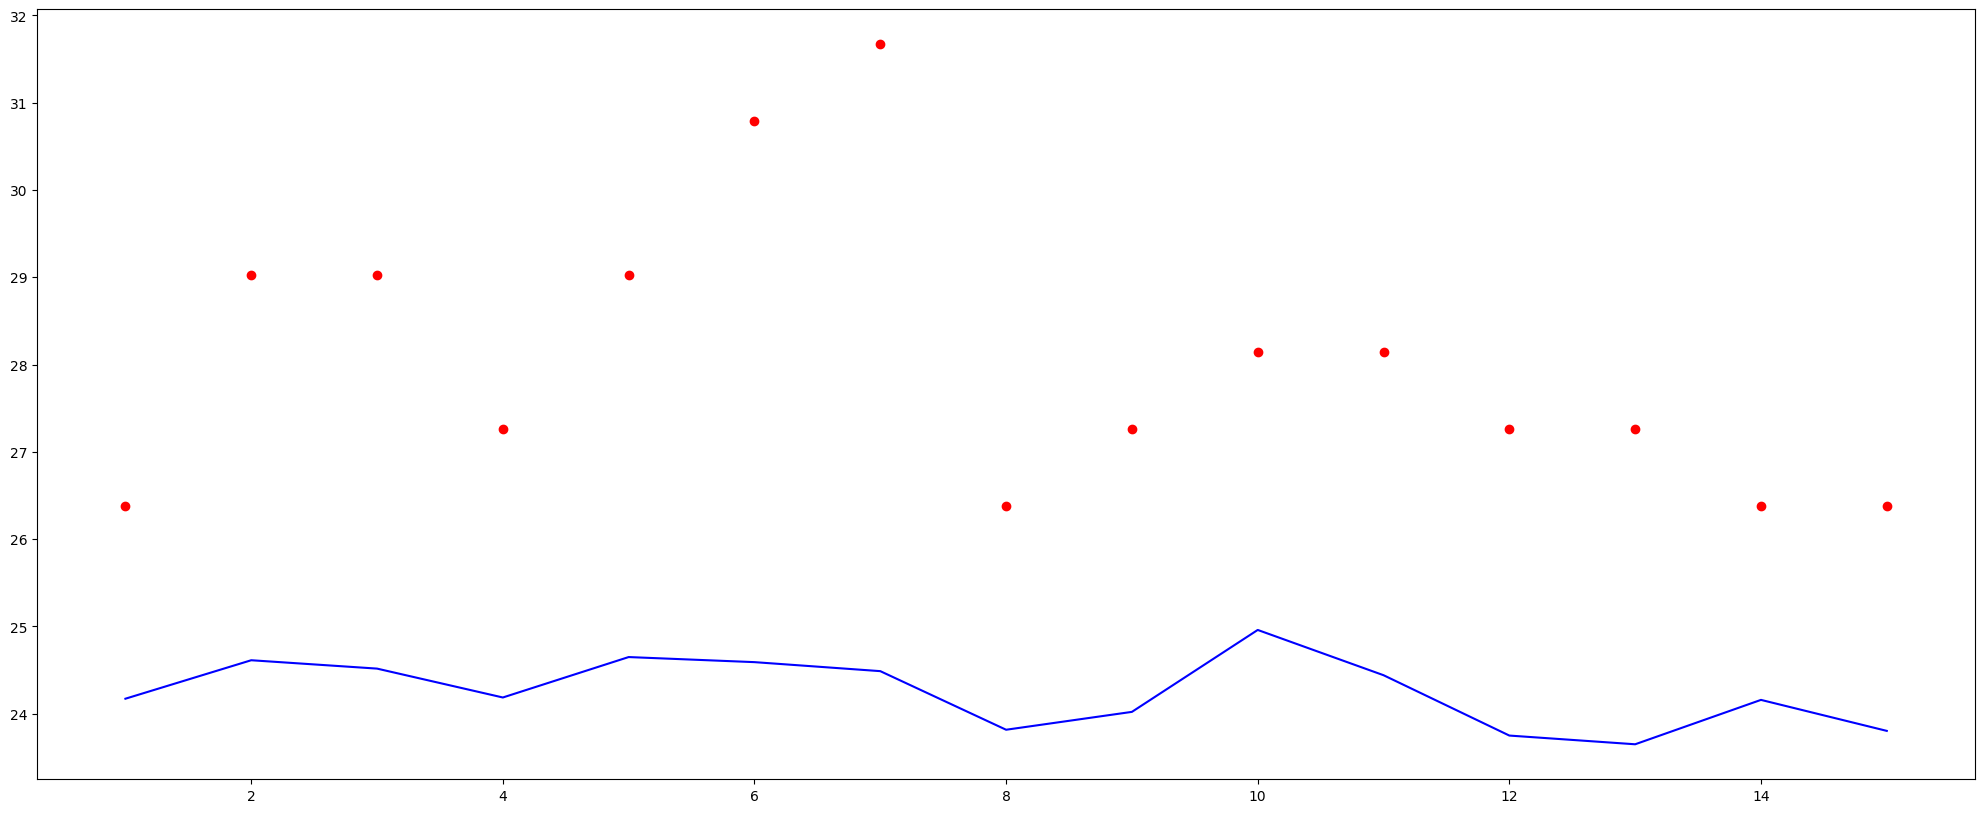

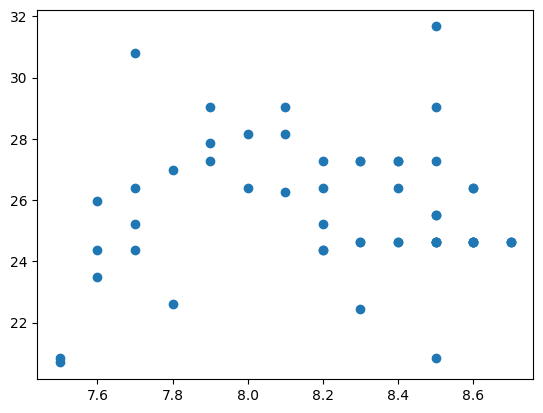

8.6 - 8.203008335135632
8.1 - 8.251529056891405
8.0 - 8.251529056891405
8.5 - 8.203008335135632
7.7 - 8.287955838885331
8.6 - 8.203008335135632
8.4 - 8.203008335135632
8.6 - 8.227251949205401
8.7 - 8.203008335135632
8.3 - 8.173165906124792
8.4 - 8.227251949205401
8.6 - 8.227251949205401
7.7 - 8.199286392462977
8.6 - 8.203008335135632
7.6 - 8.199286392462977
8.6 - 8.203008335135632
7.6 - 8.221736042000547
7.5 - 8.148888798438788
MAE 0.38801285990794504
MSE 0.17645524742198945
RMSE 0.42006576559151954
MAPE 0.0478458038163116
R2 Score -0.012781225238699845
validation results on pH
MAE 0.22262819389266042
MSE 0.07301468979475326
RMSE 0.2702123050394879
MAPE 0.027485870648483655
R2 Score -0.020391627566427983
-----For WQI with Salinity  Regression relation-----


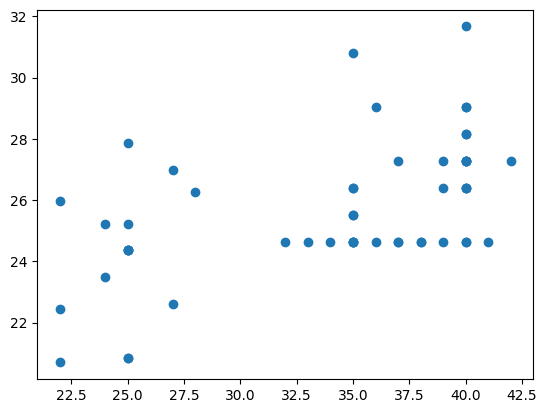

33 - 32.474931571943614
40 - 37.715076893257816
40 - 37.715076893257816
32 - 32.474931571943614
35 - 41.64909980818468
38 - 32.474931571943614
34 - 32.474931571943614
40 - 35.09319560929452
40 - 32.474931571943614
22 - 29.252006209354775
40 - 35.09319560929452
35 - 35.09319560929452
25 - 32.07296886865817
37 - 32.474931571943614
25 - 32.07296886865817
36 - 32.474931571943614
22 - 34.497488161293084
22 - 26.630124925391478
MAE 4.626480532556229
MSE 30.88708534731094
RMSE 5.557615077289083
MAPE 0.15864300566986583
R2 Score 0.30135327753918273
validation results on Salinity
MAE 7.146089406404266
MSE 55.761083821731184
RMSE 7.467334452248084
MAPE 0.18051985575241428
R2 Score -13.192583551911216
-----For WQI with Ammonia SVR relation-----


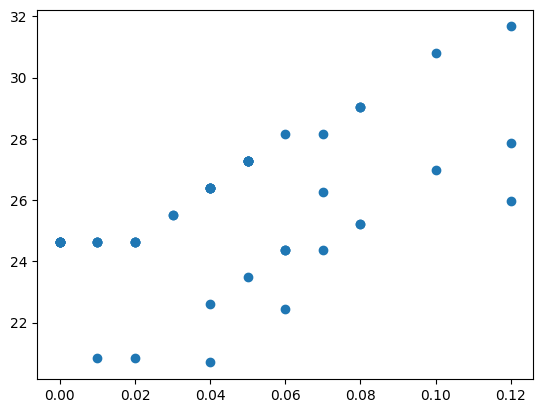

0.02 - 0.014300834578218471
0.06 - 0.08537832946164603
0.07 - 0.08537832946164603
0.02 - 0.014300834578218471
0.1 - 0.0956719894682201
0.0 - 0.014300834578218471
0.01 - 0.014300834578218471
0.04 - 0.05172331930840061
0.0 - 0.014300834578218471
0.06 - 0.03260748043236435
0.04 - 0.05172331930840061
0.04 - 0.05172331930840061
0.06 - 0.03091813561051953
0.0 - 0.014300834578218471
0.07 - 0.03091813561051953
0.0 - 0.014300834578218471
0.12 - 0.051178874863956156
0.04 - 0.03227914709903102
MAE 0.018069742083252145
MSE 0.0005629201387883252
RMSE 0.023725938101333846
MAPE 14312274061678.447
R2 Score 0.5186431117249475
validation results on Ammonia
MAE 0.035127656044076305
MSE 0.00207227623549391
RMSE 0.045522260878540624
MAPE 0.474125594272183
R2 Score -2.730097223889039


In [261]:
predictedWQI,gtforRE = predictWQI(dataframe,"HWQI")
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)

WQIandParameters(np.array(dataframe['HWQI']).reshape(-1, 1),dataframe[parameters],predictedWQI.reshape(-1, 1),gtforRE)

In [262]:
## Not good code

In [263]:


# #to train model to predict the WQI using band  indcies using ML
# def WQIandBands(df1,WQI):
#   print('-----For WQI prediction with Bands with SVR algo -----')
#   X_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['pH']]
#   X_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['pH']]
#   # X_train, X_test, y_train, y_test = train_test_split(Bandsndices, WQI, test_size=0.33, random_state=42)
#   model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
#   model.fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   return prediction


# def CM(actual, predicted):
#   fig = plt.figure()
#   plt.scatter(actual, predicted)
#   plt.show()

# def LRegression(WQI,GT):
#   X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
#   model = LinearRegression().fit(X_train, y_train)
#   # model1 = SVR(kernel='rbf', C=1.0, epsilon=0.2).fit(X_train, y_train)
#   # model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   for x,y in zip(y_test.values,prediction):
#     print(x,'-',y)

#   CM(WQI,GT)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   # return model.coef_,model.intercept_
# #to predict the parameters from WQI



# def WQIandParameters(WQI,GT):
#   print('-----For WQI with pH Regression relation-----')
#   LRegression(WQI,GT['pH'])
#   print('-----For WQI with Salinity  Regression relation-----')
#   LRegression(WQI,GT['Salinity'])
#   print('-----For WQI with Ammonia SVR relation-----')
#   LRegression(WQI,GT['Ammonia'])
#   return None



## WQI with only bands

In [264]:
# WQI = WQIcalculation(df1 ,GT1)
# # len(WQI)
# WQIandBands(df1,WQI)
# WQIandParameters(np.array(WQI).reshape(-1, 1),GT)

## WQI with  top  10 combination indices

In [265]:
#   corrwithWQI = newdf.corrwith(newdf['WQI_cal'])
# type(corrwithWQI)
# corrdict  = corrwithWQI.to_dict()
# sortedkeys = sorted(corrdict, key=corrdict.get, reverse=True)
# for r in sortedkeys[:11]:
#     print(r, corrdict[r])

In [266]:
# newtraindf = newdf[sortedkeys].drop('WQI_cal',axis = 1)
# scaler = StandardScaler()
# scaler.fit(newtraindf)
# newscaledtraindf = scaler.transform(newtraindf)
# WQIandBands(newscaledtraindf,WQI)

In [267]:
# plt.scatter(df['norm_NarrowNIR_SWIR1'],df['WQI_cal'])
# plt.scatter(df['norm_NarrowNIR_SWIR2'],df['WQI_cal'])
# plt.scatter(df['norm_WaterVapour_SWIR2'],df['WQI_cal'])

## WQI with  PCA 3 bands